# Kaggle Top Spotify songs from 2010-2019

https://www.kaggle.com/leonardopena/top-spotify-songs-from-20102019-by-year

#### Autors: Damià Turu i Èric Rodríguez

## Objectiu

Utilitzar la base de dades de Kaggle del Top Spotify songs from 2010-2019 per entrenar un classificador que ens digui a quin percentatge de popularitat pot pèrtanyer una nova canço de spotify segons les seves dades. És a dir, pel nostre case el target serà l'atribut 'pop'.

## Continguts

1. EDA i Preprocessing
* Anàlisi de tamany i tipologia de dades
* Anàlisi i modificació del target
* Encoding de categòriques
* Valoració de correlacions
* Normalització
* Equilibració de classes

2. Metric Selection
* Selecció de la millor mètrica
* Visualització de ROC/AUC

3. Model Selection i Crossvalidation
* Selecció del millor model
* Cerca d'hiperparàmetres

4. Anàlisi Final

Primer de tot, importem llibreries essencials, a més de les dades i observem que s'han importat correctament. Ho veiem a continuació:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.preprocessing import LabelEncoder

df=pd.read_csv("top10s.csv", encoding='latin1')

print(df.dtypes)
print(df.head())

Unnamed: 0     int64
title         object
artist        object
top genre     object
year           int64
bpm            int64
nrgy           int64
dnce           int64
dB             int64
live           int64
val            int64
dur            int64
acous          int64
spch           int64
pop            int64
dtype: object
   Unnamed: 0                 title      artist        top genre  year  bpm  \
0           1      Hey, Soul Sister       Train       neo mellow  2010   97   
1           2  Love The Way You Lie      Eminem  detroit hip hop  2010   87   
2           3               TiK ToK       Kesha        dance pop  2010  120   
3           4           Bad Romance   Lady Gaga        dance pop  2010  119   
4           5  Just the Way You Are  Bruno Mars              pop  2010  109   

   nrgy  dnce  dB  live  val  dur  acous  spch  pop  
0    89    67  -4     8   80  217     19     4   83  
1    93    75  -5    52   64  263     24    23   82  
2    84    76  -3    29   71  200 

## 1. EDA i Preprocessing

### - Anàlisi de tamany i tipologia de dades

Mirem quantes mostres i quants atributs té la nostre base de dades i què significa cadascun.

In [2]:
print("Número de mostres:", df.shape[0])
print("Número d'atributs:", df.columns.shape[0])

Número de mostres: 603
Número d'atributs: 15


Cada atribut significa:

-Unnamed: ID

-title: Song's title

-artist: Song's artist

-top genre: The genre of the track

-year: Song's year in the Billboard

-bpm: Beats.Per.Minute - The tempo of the song

-nrgy: Energy- The energy of a song - the higher the value, the more energtic. song

-dnce: Danceability - The higher the value, the easier it is to dance to this song

-dB: Loudness..dB.. - The higher the value, the louder the song

-live: Liveness - The higher the value, the more likely the song is a live recording

-val: Valence - The higher the value, the more positive mood for the song

-dur: Length - The duration of the song

-acous: Acousticness.. - The higher the value the more acoustic the song is

-spch: Speechiness - The higher the value the more spoken word the song contains

-pop: Popularity- The higher the value the more popular the song is

Com que la columna id no té nom, de moment li assignem.

In [3]:
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

El tipus d'atributs que tenim són:

In [4]:
print(df.dtypes)

id            int64
title        object
artist       object
top genre    object
year          int64
bpm           int64
nrgy          int64
dnce          int64
dB            int64
live          int64
val           int64
dur           int64
acous         int64
spch          int64
pop           int64
dtype: object


-Categòrics: title, artist i top genre
    
-Numèrics: id, year, bpm, nrgy, dnce, dB, live, val, dur, acous, spch i pop

Tenim NaNs a les dades?

In [5]:
print(df.isna().sum())

id           0
title        0
artist       0
top genre    0
year         0
bpm          0
nrgy         0
dnce         0
dB           0
live         0
val          0
dur          0
acous        0
spch         0
pop          0
dtype: int64


Sorprenentment no tenim NaNs a les dades, així que no hem de tractar res en aquest cas.

### - Anàlisi i modificació del target

En el nostre cas el target és la columna 'pop', anem a fer un anàlisi més profund.

In [6]:
print(df['pop'].value_counts(), "\n")
print(df['pop'].unique(), "\n")

# Mostrem les primeres files
print("Target abans de convertir en intervals:")
print(df['pop'].head())

# Creem 10 categories (0 a 9) dividint uniformement el rang de la columna 'pop'
df['pop'] = pd.cut(df['pop'], bins=10, labels=False)

# Mostrem les primeres files per verificar
print("\nTarget després de convertir en intervals:")
print(df['pop'].head())

pop
72    33
78    27
73    26
76    24
65    23
      ..
48     1
27     1
35     1
7      1
39     1
Name: count, Length: 71, dtype: int64 

[83 82 80 79 78 77 76 73 72 71 70 69 68 66 65 64 63 62 61 59 58 57 56 55
 52 49 33  0 81 75 74 67 60 54 50 46 38 31 28 27 25  7 88 85 51 45 43 42
 41 36 35 86 44 37 30 84 47 39 34 18 53 48 29 87 99 97 96 95 93 92 90] 

Target abans de convertir en intervals:
0    83
1    82
2    80
3    79
4    78
Name: pop, dtype: int64

Target després de convertir en intervals:
0    8
1    8
2    8
3    7
4    7
Name: pop, dtype: int64


Hem optat per discretitzar el target en 10 intervals de manera que els valors de la columna 'pop' poden anar de 0 a 9:
- 0: [0, 1, 2,..., 9]
- 1: [10, 11, 12,.., 19]
- 2: [20, 21, 22,.., 29]
- 3: [30, 31, 32,.., 39]
- 4: [40, 41, 42,.., 49]
- 5: [50, 51, 52,.., 59]
- 6: [60, 61, 62,.., 69]
- 7: [70, 71, 72,.., 79]
- 8: [80, 81, 82,.., 89]
- 9: [90, 91, 92,.., 99]

### - Encoding de categòriques

Anem a analitzar una mica més les variables categòriques. Analitzem quines cançons es repeteixen perquè apareixen en anys diferents i mirem si l'artista i popularitat coincideixen.

In [13]:
# Contem quantes vegades es repeteix cada títol
frequencia_titol = df['title'].value_counts()

# Filtrem els títols que es repeteixen més d'una vegada
titols_repetits = frequencia_titol[frequencia_titol > 1].index

# Filtrem les files que corresponen a aquests titols repetits
files_repetides = df[df['title'].isin(titols_repetits)]

# Mostrem les files
print(files_repetides[['title', 'artist', 'pop']].sort_values(by='title'))

                                               title             artist  pop
239  A Little Party Never Killed Nobody (All We Got)             Fergie    6
178  A Little Party Never Killed Nobody (All We Got)             Fergie    6
398                                        All I Ask              Adele    7
473                                        All I Ask              Adele    7
95           Castle Walls (feat. Christina Aguilera)               T.I.    4
48           Castle Walls (feat. Christina Aguilera)               T.I.    4
301                                          Company      Justin Bieber    7
396                                          Company      Justin Bieber    7
548                                       First Time               Kygo    7
474                                       First Time               Kygo    7
295                                            Hello              Adele    7
50                                             Hello     Martin Solveig    0

Donat que tenim unes quantes cançons que es repeteixen perquè apareixen en anys diferents i tenen la mateixa popularitat, optarem per quedar-nos amb la més recent si l'artista coincideix.

In [15]:
# Ordenem el DataFrame por títol, artista i any en ordre descendent
df.sort_values(by=['title', 'artist', 'year'], ascending=[True, True, False], inplace=True)

# Eliminem duplicats conservant la mostra més recent
df.drop_duplicates(subset=['title', 'artist'], keep='first', inplace=True)

# Reiniciem els índexs del DataFrame
df.reset_index(drop=True, inplace=True)


# Contem quantes vegades es repeteix cada títol
frequencia_titol = df['title'].value_counts()

# Filtrem els títols que es repeteixen més d'una vegada
titols_repetits = frequencia_titol[frequencia_titol > 1].index

# Filtrem les files que corresponen a aquests titols repetits
files_repetides = df[df['title'].isin(titols_repetits)]

# Mostrem les files
print(files_repetides[['title', 'artist', 'pop']].sort_values(by='title'))

             title             artist  pop
197          Hello              Adele    7
198          Hello     Martin Solveig    0
220      I Like It            Cardi B    8
221      I Like It   Enrique Iglesias    6
413  Say Something  A Great Big World    6
414  Say Something  Justin Timberlake    7


Tornem a mostrar les cançons repetides per comprovar que s'hagin eliminat les que tenen artista diferent, i així és.

Provem de mirar quants artistes diferents tenim:

In [16]:
print(df['artist'].value_counts())

artist
Katy Perry       17
Rihanna          15
Maroon 5         14
Justin Bieber    14
Lady Gaga        14
                 ..
Ne-Yo             1
N.E.R.D           1
Lea Michele       1
Disclosure        1
Tinie Tempah      1
Name: count, Length: 184, dtype: int64


Podem veure que el conjunt d'artistes està bastant desbalancejat, veient que hi ha molts que només apareixen un cop. Més endavant eliminarem aquesta característica ja que no creiem que ens pugui resultar gaire útil donada la seva distibució.

Provem de mirar quants gèneres diferents tenim:

In [17]:
print(df['top genre'].value_counts())
print(df['top genre'].nunique())

top genre
dance pop                    324
pop                           56
canadian pop                  31
barbadian pop                 15
boy band                      15
electropop                    13
big room                      10
british soul                  10
neo mellow                     9
art pop                        8
canadian contemporary r&b      7
australian dance               6
hip pop                        6
complextro                     6
australian pop                 5
latin                          4
hip hop                        4
permanent wave                 4
edm                            4
atl hip hop                    4
colombian pop                  3
brostep                        2
canadian hip hop               2
indie pop                      2
escape room                    2
downtempo                      2
detroit hip hop                2
belgian edm                    2
tropical house                 2
baroque pop                    2


En aquest cas, veient que, principalment, hi ha una grandíssima quantitat de mostres amb el gènere dance pop i, el segon més gran sent pop, hem decidit juntar tots els que continguin la paraula pop. Com que hi ha alguns subgèneres de hip hop, també els hem ajuntat. I per acabar, hem juntat també els gèneres que apareixen menys de 5 vegades ja que hi ha molts que apareixen pocs cops.

In [18]:
df['top genre'] = df['top genre'].apply(
    lambda x: 'pop' if 'pop' in x else ('hip hop' if 'hip hop' in x else x)
)
genre_counts = df['top genre'].value_counts()
df['top genre'] = df['top genre'].apply(
    lambda x: 'other' if genre_counts[x] < 5 else x
)

print(df['top genre'].value_counts())

top genre
pop                          475
other                         36
boy band                      15
hip hop                       13
big room                      10
british soul                  10
neo mellow                     9
canadian contemporary r&b      7
australian dance               6
complextro                     6
Name: count, dtype: int64


A continuació codifiquem les columnes categòriques per poder mostrar la matriu de correlacions.

In [19]:
# Convertim totes les columnes categòriques a valors numèrics amb un label encoder
for col in df[['title', 'artist', 'top genre']]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

Comprovem amb les primeres i últimes mostres del dataframe que s'hagin codificat els atributs categòrics:

In [21]:
print(df)

      id  title  artist  top genre  year  bpm  nrgy  dnce  dB  live  val  dur  \
0    200      0     112          9  2013  107    76    68  -5    31   45  200   
1    241      1     168          9  2014  128    92    79  -3     8   66  184   
2    174      2     183          9  2013  128    61    80  -6     7   40  280   
3    570      3     166          9  2018  160    84    58  -5    10   50  190   
4     88      4      16          9  2011   63    38    30  -7     7   26  274   
..   ...    ...     ...        ...   ...  ...   ...   ...  ..   ...  ...  ...   
582  491    579     121          9  2017  122    87    55  -5    14   33  249   
583   20    580      89          9  2010  120    61    83  -4     9   76  187   
584  539    581     157          9  2018  100    60    53  -7    13   32  191   
585  234    582      31          9  2014  144    49    44  -6    11   25  251   
586  514    583      10          9  2018  122    71    70  -6    29   35  206   

     acous  spch  pop  
0  

### - Valoració de correlacions

Per analitzar les correlacions entre atributs, anem a crear la matriu de correlacions i l'analiztem.

<Axes: >

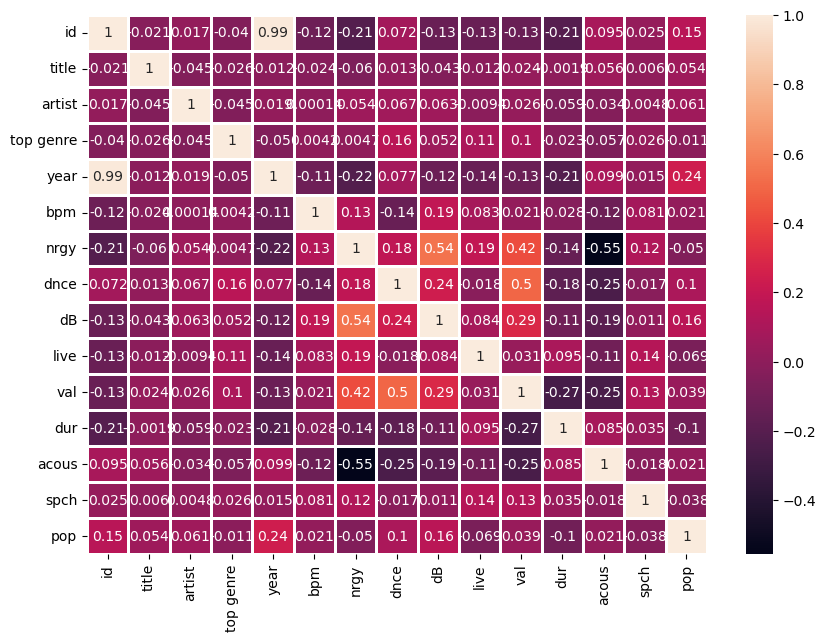

In [22]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, linewidths=2)

En el mapa de calor podem observar els atributs més correlacionats com els valors que més s'allunyen del 0. Podem veure que els que més correlacionats estan són:
- Els 'dB' amb la 'nrgy' (0.54) significant que com més decibels més energia té la cançó.
- La 'acous' amb la 'nrgy' (-0.55), això vol dir que com més acústica sigui la cançó menys energia dona.
- La 'dnce ' amb la 'val' (0.5), com més ganes de ballar produeix la cançó, més valència té.
- La 'nrgy' amb la 'val' (0.42), com més energia, més valència.

Com podem veure respecte el target no hi ha cap atribut que estigui estrictament correlacionat amb el target com a molt podem considerar els que tenen valors més alts que són:
- year: 0.24
- dB: 0.16
- dnce: 0.1
- dur: -0.1

Ara agruparem els valors de les diferents característiques relacionades amb el target per mostrar l'interaval de popularitat de cada valor:

In [23]:
df[["year",'pop']].groupby(["year"], as_index = False).mean().sort_values(by='year')

,year,pop
0,2010,6.000000
1,2011,5.698113
2,2012,6.264706
3,2013,5.985714
4,2014,5.810345
5,2015,5.931818
6,2016,5.962025
7,2017,6.428571
8,2018,6.796875
9,2019,8.000000


Sembla ser que els últims anys la popularitat de les cançons és més alta, concretament sent destacable l'últim, el 2019, amb promig de classe 8.

In [24]:
df[["dB",'pop']].groupby(["dB"], as_index = False).mean().sort_values(by='dB')

,dB,pop
0,-60,0.000000
1,-15,4.000000
2,-13,3.000000
3,-12,6.000000
4,-11,5.000000
5,-10,5.333333
6,-9,5.937500
7,-8,6.310345
8,-7,6.353659
9,-6,6.373984


Per aquest cas, amb valors de dB més baixos la popularitat es mostra més baixa. També veiem un cas estrany molt allunyat de la resta de valors que és el de dB = -60. Això ho analitzarem més endavant quan veiem la distribució d'aquest atribut.

In [25]:
df[["dnce",'pop']].groupby(["dnce"], as_index = False).mean().sort_values(by='dnce')

,dnce,pop
0,0,0.000000
1,23,5.000000
2,26,6.333333
3,27,4.000000
4,28,5.000000
...,...,...
65,91,7.000000
66,92,6.000000
67,93,6.000000
68,96,5.000000


Aquí podem veure que el rang de valors és relativament al (70), dificultant veure de quina manera creix la popularitat. Com a molt podem dir que també veiem el cas estrany en que hi ha un valor que és 0, però ho veurem més tard.

In [26]:
df[["dur",'pop']].groupby(["dur"], as_index = False).mean().sort_values(by='dur')

,dur,pop
0,134,6.0
1,148,8.0
2,157,6.0
3,158,5.0
4,159,7.5
...,...,...
139,353,5.0
140,354,7.0
141,379,7.0
142,403,5.0


Per la duració, tenim un cas similar a l'anterior només que és tenim una mica més del doble de rang de valors. Poc podem dir, tot i que ja ens ho imaginàvem donat el baix valor de correlació.

 ### - Normaliztació

Ara anem a veure les distribucions dels atributs:

In [27]:
df.describe()

,id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
count,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000
mean,303.681431,291.419080,88.856899,8.231687,2014.614991,118.659284,70.494037,64.480409,-5.568995,17.853492,52.226576,224.597956,14.233390,8.275980,6.190801
std,174.483633,168.442336,53.241641,1.995939,2.607088,24.860493,16.271729,13.384988,2.825395,13.155762,22.512752,34.151118,20.560534,7.303664,1.481761
min,1.000000,0.000000,0.000000,0.000000,2010.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,134.000000,0.000000,0.000000,0.000000
25%,152.500000,146.500000,41.000000,9.000000,2013.000000,100.000000,61.000000,57.000000,-6.000000,9.000000,35.000000,202.000000,2.000000,4.000000,6.000000
50%,304.000000,291.000000,87.000000,9.000000,2015.000000,120.000000,74.000000,66.000000,-5.000000,12.000000,52.000000,221.000000,6.000000,5.000000,6.000000
75%,454.500000,436.500000,136.500000,9.000000,2017.000000,129.000000,82.000000,73.000000,-4.000000,24.000000,69.000000,239.500000,17.000000,9.000000,7.000000
max,603.000000,583.000000,183.000000,9.000000,2019.000000,206.000000,98.000000,97.000000,-2.000000,74.000000,98.000000,424.000000,99.000000,48.000000,9.000000


Primer analitzem els atributs numèrics continus ja que tenen desviacions estàndards considerablement altes:

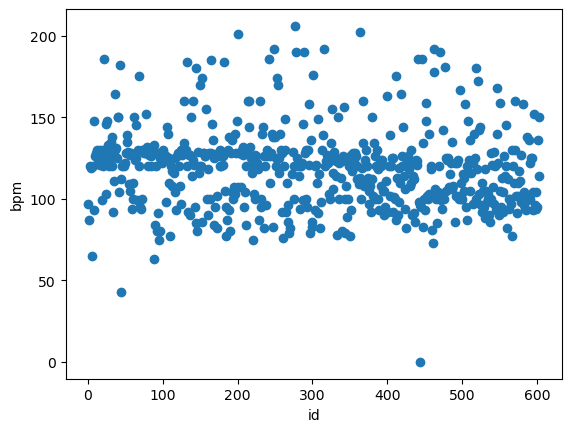

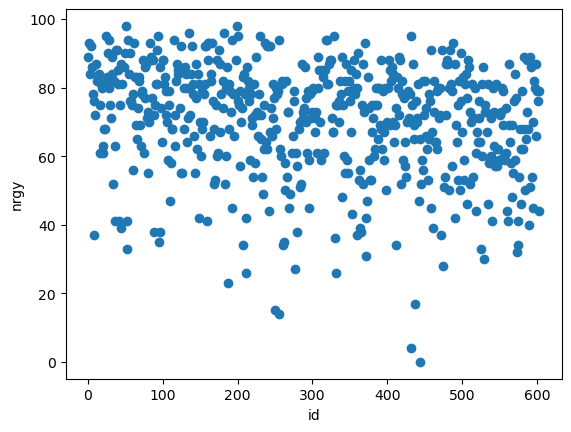

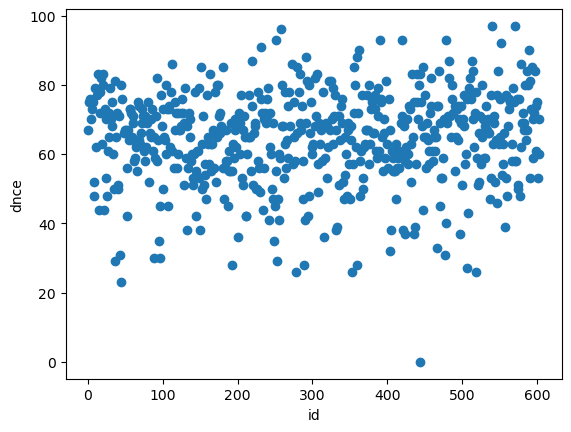

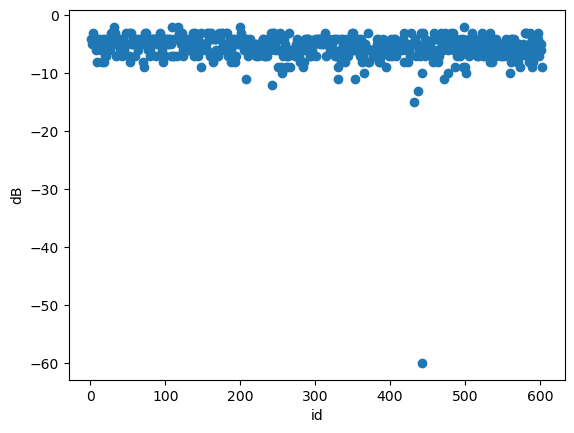

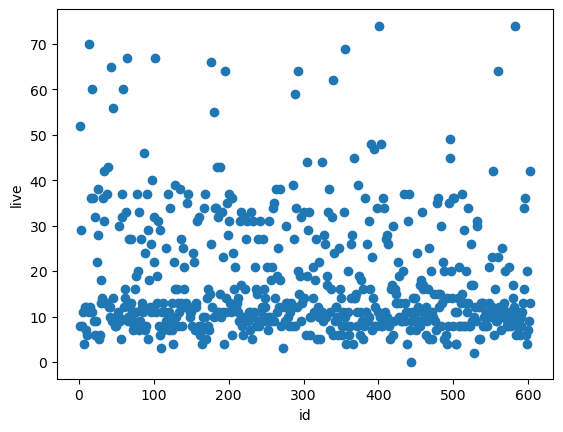

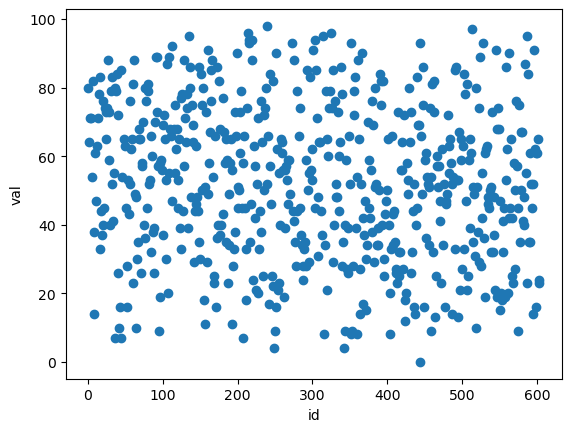

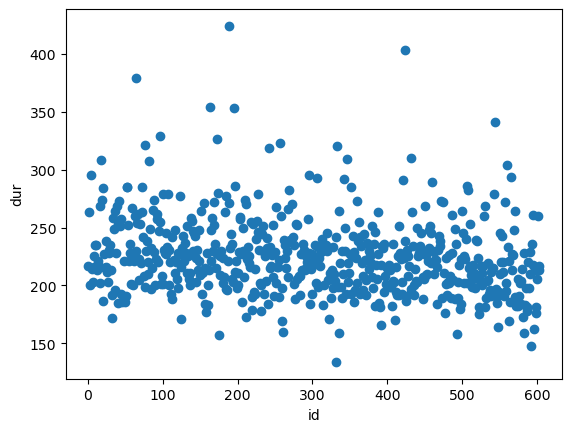

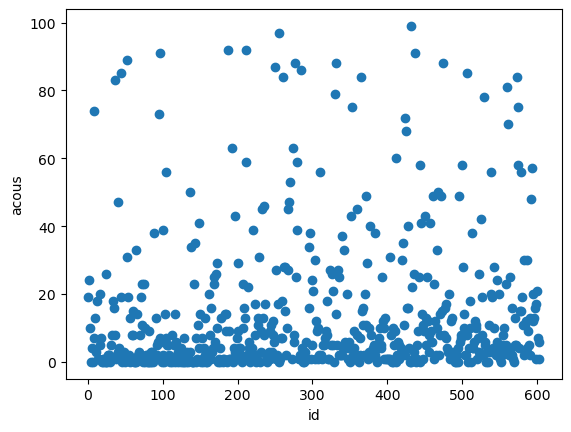

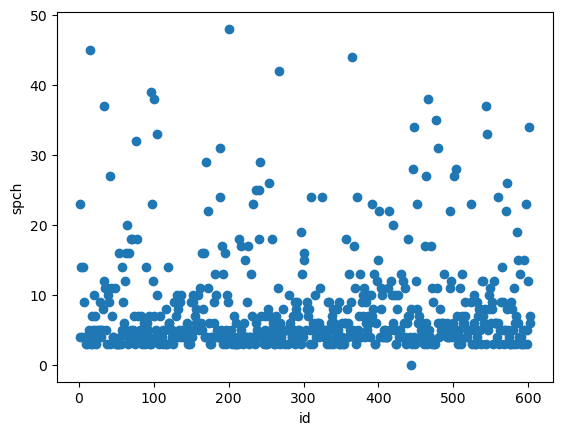

In [28]:
# Distribució de bpm
plt.scatter(df["id"],df["bpm"])
plt.xlabel("id")
plt.ylabel("bpm")
plt.show()

# Distribució de nrgy
plt.scatter(df["id"],df["nrgy"])
plt.xlabel("id")
plt.ylabel("nrgy")
plt.show()

# Distribució de dnce
plt.scatter(df["id"],df["dnce"])
plt.xlabel("id")
plt.ylabel("dnce")
plt.show()

# Distribució de dB
plt.scatter(df["id"],df["dB"])
plt.xlabel("id")
plt.ylabel("dB")
plt.show()

# Distribució de live
plt.scatter(df["id"],df["live"])
plt.xlabel("id")
plt.ylabel("live")
plt.show()

# Distribució de val
plt.scatter(df["id"],df["val"])
plt.xlabel("id")
plt.ylabel("val")
plt.show()

# Distribució de dur
plt.scatter(df["id"],df["dur"])
plt.xlabel("id")
plt.ylabel("dur")
plt.show()

# Distribució de acous
plt.scatter(df["id"],df["acous"])
plt.xlabel("id")
plt.ylabel("acous")
plt.show()

# Distribució de spch
plt.scatter(df["id"],df["spch"])
plt.xlabel("id")
plt.ylabel("spch")
plt.show()

Primer de tot, si ens fixem sembla ser que hi ha una mostra estranya la qual el seu valor resulta ser un outlier radical en la majoria de casos, sent 0. Ho comprovem:

In [29]:
print(df[df['bpm'] == 0])

      id  title  artist  top genre  year  bpm  nrgy  dnce  dB  live  val  dur  \
322  443    320       4          3  2016    0     0     0 -60     0    0  227   

     acous  spch  pop  
322      0     0    0  


Aquesta mostra és la cançó amb 'id' 443 que equival a la cançó "Million Years Ago" de l'artista Adele. Efectivament, aquesta mostra sembla ser estranya ja que l'únic atribut numèric continu que sembla ser correcte és la 'dur', així que considerem eliminar-la del nostre dataset. I tornem a mostrar la taula d'estadístiques descriptives ja que s'hauran actualitzat els mínims.

In [30]:
df = df[df['id'] != 443]

In [31]:
df.describe()

,id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
count,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000
mean,303.443686,291.370307,89.001706,8.240614,2014.612628,118.861775,70.614334,64.590444,-5.476109,17.883959,52.315700,224.593857,14.257679,8.290102,6.201365
std,174.537517,168.582094,53.171308,1.985879,2.608686,24.392440,16.022252,13.128016,1.709784,13.146259,22.428103,34.180150,20.569669,7.301877,1.460733
min,1.000000,0.000000,0.000000,0.000000,2010.000000,43.000000,4.000000,23.000000,-15.000000,2.000000,4.000000,134.000000,0.000000,3.000000,0.000000
25%,152.250000,146.250000,41.000000,9.000000,2013.000000,100.000000,61.000000,57.000000,-6.000000,9.000000,35.000000,202.000000,2.000000,4.000000,6.000000
50%,303.500000,290.500000,87.000000,9.000000,2015.000000,120.000000,74.000000,66.000000,-5.000000,12.000000,52.000000,220.500000,6.000000,5.000000,6.000000
75%,454.750000,436.750000,136.750000,9.000000,2017.000000,129.000000,82.000000,73.000000,-4.000000,24.000000,69.000000,239.750000,17.000000,9.000000,7.000000
max,603.000000,583.000000,183.000000,9.000000,2019.000000,206.000000,98.000000,97.000000,-2.000000,74.000000,98.000000,424.000000,99.000000,48.000000,9.000000


A continuació, decidim si utilitzem un StandardScaler o un RobustScaler per normalitzar l'atribut, depenent de com siguin les distribucions mirant les gràfiques anteriors (sense tenir en compte els valors de 0 en tots els atributs, excepte 'dB' que és -60), la mitjana i els valors mínims i màxims.

- StandardScaler: La seva distribució no presenta masses outliers i els seus valors es troben concentrats al voltant de la mitjana. Atributs: 'bpm', 'nrgy', 'dnce', 'dB', i 'val'.

- RobustScaler: La seva distribució és desigual mostrant alguns outliers i valors allunyats de la mitjana. Atributs: 'live', 'dur', i 'acous'.

In [32]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler=StandardScaler()

df[['bpm', 'nrgy', 'dnce', 'dB', 'val']]=scaler.fit_transform(df[['bpm', 'nrgy', 'dnce', 'dB', 'val']])

scaler=RobustScaler()

df[['live', 'dur', 'acous', 'spch']]=scaler.fit_transform(df[['live', 'dur', 'acous', 'spch']])

df.describe()

,id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
count,586.000000,586.000000,586.000000,586.000000,586.000000,5.860000e+02,5.860000e+02,5.860000e+02,5.860000e+02,586.000000,5.860000e+02,586.000000,586.000000,586.000000,586.000000
mean,303.443686,291.370307,89.001706,8.240614,2014.612628,1.303470e-16,4.850121e-17,3.273832e-16,-6.062651e-17,0.392264,-1.273157e-16,0.108447,0.550512,0.658020,6.201365
std,174.537517,168.582094,53.171308,1.985879,2.608686,1.000854e+00,1.000854e+00,1.000854e+00,1.000854e+00,0.876417,1.000854e+00,0.905434,1.371311,1.460375,1.460733
min,1.000000,0.000000,0.000000,0.000000,2010.000000,-3.112710e+00,-4.161166e+00,-3.170774e+00,-5.574991e+00,-0.666667,-2.156089e+00,-2.291391,-0.400000,-0.400000,0.000000
25%,152.250000,146.250000,41.000000,9.000000,2013.000000,-7.739238e-01,-6.005740e-01,-5.786806e-01,-3.066694e-01,-0.200000,-7.727133e-01,-0.490066,-0.266667,-0.200000,6.000000
50%,303.500000,290.500000,87.000000,9.000000,2015.000000,4.670290e-02,2.114908e-01,1.074618e-01,2.786996e-01,0.000000,-1.408810e-02,0.000000,0.000000,0.000000,6.000000
75%,454.750000,436.750000,136.750000,9.000000,2017.000000,4.159849e-01,7.112229e-01,6.411282e-01,8.640686e-01,0.800000,7.445371e-01,0.509934,0.733333,0.800000,7.000000
max,603.000000,583.000000,183.000000,9.000000,2019.000000,3.575398e+00,1.710687e+00,2.470841e+00,2.034807e+00,4.133333,2.038662e+00,5.390728,6.200000,8.600000,9.000000


Ara ja tenim els nostres atributs númerics continus normalitzats. Com podem veure hem aconseguit reduir considerablement la desviació estàndard.

 ### - Equilibració de classes

Per acabar amb aquest apartat, anem a veure si la distribució del target està equilibrada.

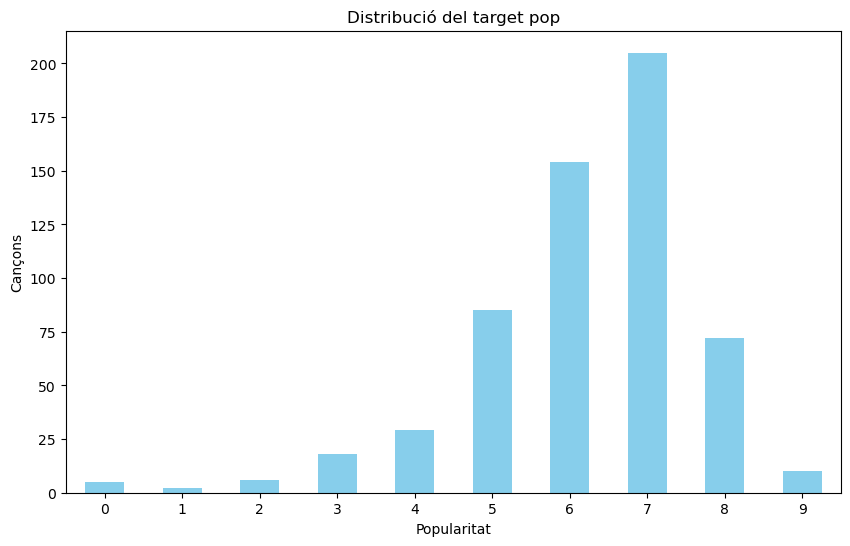

pop
0      5
1      2
2      6
3     18
4     29
5     85
6    154
7    205
8     72
9     10
Name: count, dtype: int64


In [33]:
# Agafem els valors de 'pop' ordenats
pop_counts = df['pop'].value_counts().sort_index()

plt.figure(figsize=(10,6))
pop_counts.plot(kind='bar', color='skyblue')
plt.title('Distribució del target pop')
plt.xlabel('Popularitat')
plt.ylabel('Cançons')
plt.xticks(rotation=0)
plt.show()

print(pop_counts)

Com podem veure està molt desequilibrada. Sent les classes que tenen més mostres la 6 i 7 amb 154 i 205 mostres respectivament, i les classes amb menys mostres les 0, 1, 2, 3, 4 i 9 amb 5, 2, 6, 18, 29 i 10 mostres respectivament. Així doncs, hem pensat d'aplicar una tècnica de sobremostreig utilitzant SMOTE per generar dades sintètiques. Però, donat que tenim massa poques dades per les classes del 0 al 2, hem pensat de juntar les classes per sota de 5, creant una categoria que sigui "not popular".
Així quedarien les etiquetes del target 'pop' llavors:
- 0: "not popular"
- 5: "very low pop"
- 6: "low pop"
- 7: "mid pop"
- 8: "high pop"
- 9: "very high pop"

In [34]:
# Executar aquesta línea de codi per solucionar problemes de compatibilitat entre scikit-learn i imbalanced-learn
# pip install --upgrade scikit-learn imbalanced-learn

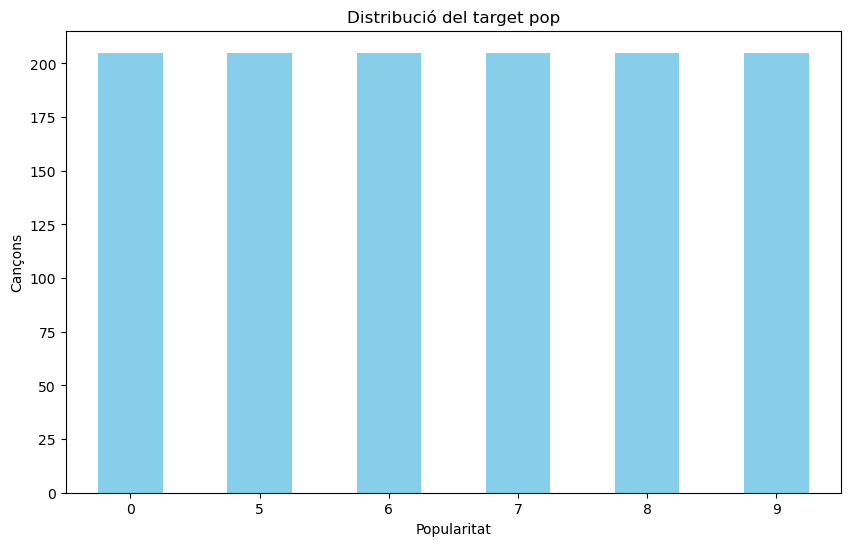

pop
0    205
5    205
6    205
7    205
8    205
9    205
Name: count, dtype: int64


In [35]:
# Combinem les classes 0, 1, 2, 3 i 4 en una sola categoria
df['pop'] = df['pop'].replace([0, 1, 2, 3, 4], 0)

# En aquest punt ja podem separar el dataset en el conjunt de cracterístiques X i el conjunt de target y.
X=df.drop('pop',axis=1)
y=df['pop']

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

df_resampled = pd.DataFrame(X, columns=X.columns)
df_resampled['pop'] = y

# Agafem els valors de 'pop' ordenats
pop_counts = df_resampled['pop'].value_counts().sort_index()

plt.figure(figsize=(10,6))
pop_counts.plot(kind='bar', color='skyblue')
plt.title('Distribució del target pop')
plt.xlabel('Popularitat')
plt.ylabel('Cançons')
plt.xticks(rotation=0)
plt.show()

print(pop_counts)

Ara ja tenim les dades balancejades.

## 2. Metric Selection

### - Selecció de la millor mètrica

Abans de res descartem els atributs que no volem considerar pel nostre model, que són bàsicament el id, i els artistes i el títol de la cançó.

In [36]:
# Aquí descartem el id, el títol i els artistes
df_resampled = df_resampled.drop(['id', 'artist', 'title'], axis=1)
# També potser hauriem de considerar codificar l'atribut 'year' (2010: 0, 2011: 1, 2012: 2, ..., 2019: 9)
df_resampled['year'] = df_resampled['year'] - 2010

Ara separarem les dades en conjunts d'entrenament i de test. Començarem per entrenar un classificador lineal (regressió logística):

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve,roc_auc_score, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve 

# Separar la X i la y amb test_train_split
X=df_resampled.drop('pop',axis=1)
y=df_resampled['pop']
classes = df_resampled['pop'].unique()  
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Per mostrar l'ùs d'aquestes funcions entrenarem un regresor logistic
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(x_train, y_train)

C:\Users\ericr\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\ericr\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

Funcio per mostrar diferents metriques així com la matriu de confusió.

In [38]:
# Donat un model i un split del dataset, aquesta funció permet visualitzar varis valors (mètriques) de rendiment (performance):
# - Accuracy
# - Precission
# - Recall (altrament dit: Sensitivity o True Positive Rate)
# - Confusion Matrix
# FONT: Coneixement, Raonament i Incertesa https://e-aules.uab.cat/2024-25/course/view.php?id=2032

def show_performance(x, y, model, average='binary', plot_title='confusion matrix'):

    predictions = model.predict(x)
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions, average=average)
    rec = recall_score(y, predictions, average=average)
    f1 = (2*prec*rec)/(prec+rec)
    conf_mat = confusion_matrix(y, predictions)

    print('-' * 25)
    print('>>> Rendiment del model:')
    print(f'- Accuracy: {round(acc, 3)}')
    print(f'- Precision: {round(prec, 3)}')
    print(f'- Recall (Sensitivity, TPR): {round(rec, 3)}')
    print(f'- F1: {round(f1, 3)}')
    print('-' * 25)
      
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)  
    disp.plot()  
    plt.title(plot_title)
    plt.show() 

-------------------------
>>> Rendiment del model:
- Accuracy: 0.423
- Precision: 0.399
- Recall (Sensitivity, TPR): 0.409
- F1: 0.404
-------------------------


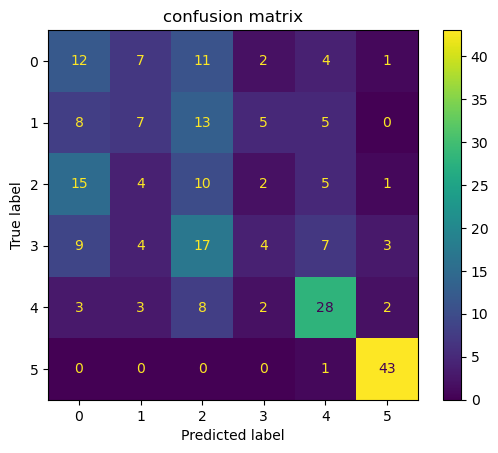

In [39]:
show_performance(x_test, y_test, model, average='macro')

El resultats inicials que hem obtingut per aquest primer model no han estat gaire bons estan tots al voltant del 40%. De la matriu de confusió podem extreure que les classes més grans (4 i 5) semblen ser les que millor es classifiquen. Això també pot ser perquè el sobremostreig que hem ha estat a partir d'un baix número de mostres.

### - Visualització de ROC/AUC

Funcio per mostrar la corva ROC, amb yellowbrick podem mostrar amb facilitat les corbes ROC de datasets multiclasse

In [40]:
from sklearn.preprocessing import LabelBinarizer

def mostra_corva_roc(X_test, y_test, model):
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)

    y_score = model.predict_proba(X_test)

    fpr = {}
    tpr = {}
    roc_auc = {}
    n_classes = y_test_bin.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Classe {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de falsos positius')
    plt.ylabel('Taxa de veritables positius')
    plt.title('Corba ROC Multiclasse')
    plt.legend(loc='lower right')
    plt.show()


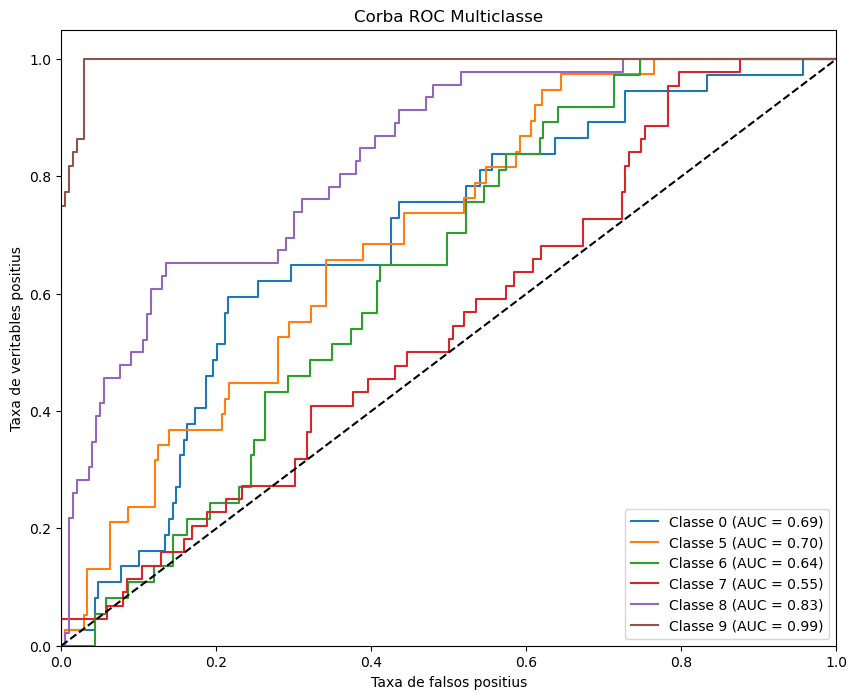

In [41]:
mostra_corva_roc(x_test, y_test, model)

Aquesta corba ROC ens reconfirma una mica el que hem dit respecte la matriu de confusió.

Funció per veure si hi ha overfitting amb la corva d'aprenentatge

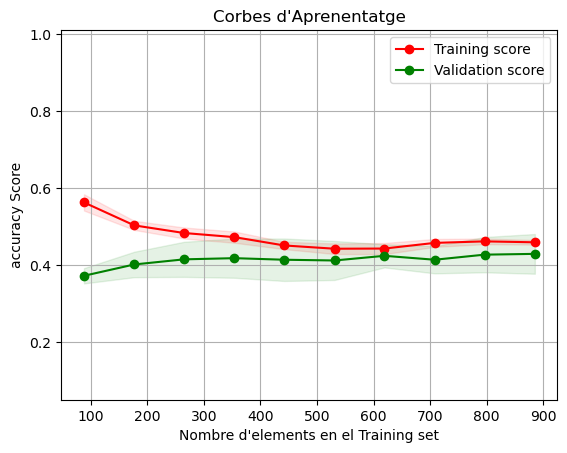

In [42]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(train_sizes, train_scores, val_scores, scoring, ylim=None):
        
    #train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure()
    plt.title('Corbes d\'Aprenentatge')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Nombre d\'elements en el Training set')
    plt.ylabel(f'{scoring} Score')
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation score')
    plt.legend(loc='best')
    plt.show()

train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=10, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
plot_learning_curve(train_sizes, train_scores, val_scores, scoring="accuracy",ylim=(0.05, 1.01))  

Tenint en compte que hem de classificar un dataset multiclasse perfectament equilibrat, i que no hi ha cap classe que tingui més importancia respecte a les altres, la mètrica que ens serveix millor per evaluar el rendiment del model serà la "Accuracy"

## 3. Model Selection i Crossvalidation

·Per a la classificació hem considerat els següents models:

- Regressió Logístic amb estrategia One vs Rest: És un model lineal fàcil d'interpretar, ràpid i eficient per problemes multiclasse com el nostre. Creiem que la majoria relacions del nostre dataset no són lineals, per tant ens serà interessant comparar l'eficiència d'un model lineal com aquest amb altres models no lineals.

- Arbre de desició: Un altre model simple i eficient per a datasets multiclasse. A difereicia del regressor logístic, els arbres de desició sol adaptarse per trobar relacions no lineals, per tant pot ser interesant utilitzar-ho.

- KNN: L'hem seleccionat per la seva senzilleça i per ser memorístic (no li cal entrenament).

- Random Forest: En cas que les relacions del nostre dataset no siguin lineals, aquest potent classificador és capaç d'ajustar-se a característiques no lineals i en situacions de falta de dades. També l'hem triat per veure la diferència d'un mètode "ensamble" en contraposició als mètodes simples. 

- AdaBoost: Un altre classificador amb metode "ensamble" per poder comparar l'eficiencia d'aquest respecte al Random Forest.

- Xarxes Neuronals Artificials: No hi ha cap dubte que les xarxes neuronals són una eina excepcional en l'àmbit de l'Aprenentatge Computacional. Aquest tipus de model s'utilitza en altres datasets, on les relacions entre les característiques i el target són molt més complexes, però ens fa curiositat saber com es comportarà en aquest dataset específic.

### - Selecció del millor model

Per avaluar el rendiment dels models hem utilitzat la Crossvalidation Stratified, perquè al ser multiclasse i partir d'un dataframe que inicialment estava bastant desbalancejat i que hem balancejat mitjançant la tècnia SMOTE, pot resultar una bona opció.

C:\Users\ericr\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\ericr\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\ericr\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\ericr\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\eri

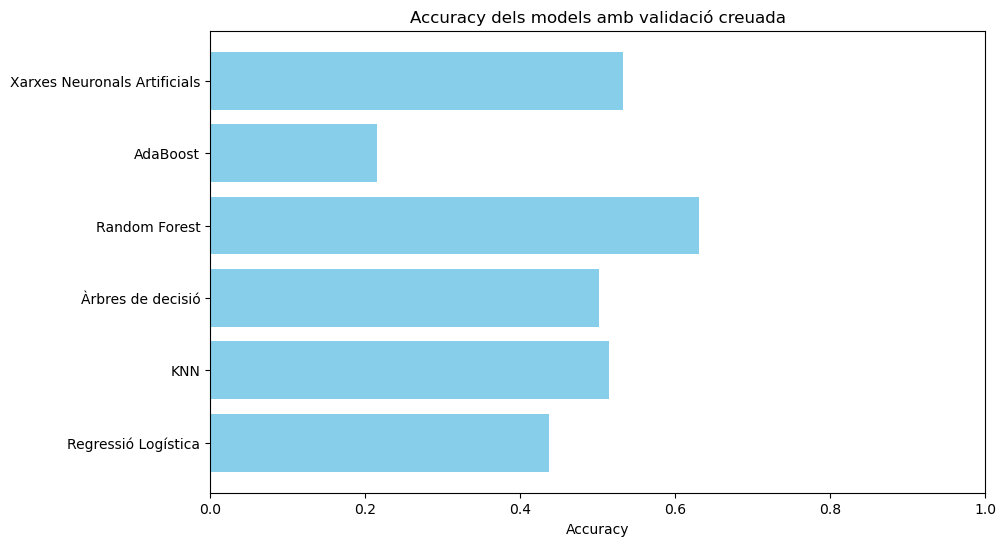

El millor model és: Random Forest amb un accuracy mitjà de:  0.6302

{'Regressió Logística': 0.43702330081431906, 'KNN': 0.5146335563976457, 'Àrbres de decisió': 0.5018624526324277, 'Random Forest': 0.6302265580907844, 'AdaBoost': 0.21598000483753926, 'Xarxes Neuronals Artificials': 0.5323147625574458}


In [43]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)


x_trainSubset, x_validation, y_trainSubset, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

models = {
    "Regressió Logística": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Àrbres de decisió": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Xarxes Neuronals Artificials": MLPClassifier(max_iter=1000)
}

results = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    cv_scores = cross_val_score(model,x_trainSubset,y_trainSubset,cv=skf,scoring="accuracy")
    results[model_name] = cv_scores.mean()
    
plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), list(results.values()), color='skyblue')
plt.xlabel('Accuracy')
plt.title('Accuracy dels models amb validació creuada')
plt.xlim(0, 1)
plt.show()


best_model = max(results, key=results.get)
print(f"El millor model és: {best_model} amb un accuracy mitjà de:  {results[best_model]:.4f}\n")
print(results)

Podem observar que el millor classificador (amb paràmetres per defecte) ha estat el Random Forest seguit de les Xarxes Neuronals (amb un Accuracy al voltant del 60%). El pitjor classificador ha estat el AdaBoost amb poc més d'un 21% d'Accuracy.

### - Cerca d'hiperparàmetres

A continuació utilitzarem la cerca Grid Search per buscar els hiperparàmetres que més convingui aplicar als nostres models. Donat que l'AdaBoost ens ha donat un rendiment tant dolent, directament el descartarem ja que no creiem que millori més que el que pot arrbar a millorar el Random Forest o les Xarxes Neuronals.

In [44]:
# ELIMINEM EL MODEL AdaBoost

del(models["AdaBoost"])

In [45]:
from sklearn.model_selection import GridSearchCV
import time

# DEFINIM ELS HIPERPARÀMETRES DE CADA MODEL DELS QUALS VOLEM BUSCAR EL VALOR ÒPTIM

param_grids = {
    "Regressió Logística": {
        'C': [0.1, 1, 10, 100, 200],
        'solver': ['liblinear', 'lbfgs']
    },
    "KNN": {
        'n_neighbors': [6,7,8,9,10,11,12],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'euclidean', 'manhattan'],
        'p' : [1,2]
    },
    "Àrbres de decisió": {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20],
        'splitter' : ['best', 'random'],
        'class_weight' : [None, 'balanced']
    },
    "Random Forest": {
        'n_estimators': [100, 200, 300, 350],
        'max_depth': [None, 10, 20],
        'criterion': ['gini', 'entropy']
    },
    "Xarxes Neuronals Artificials": {
        'hidden_layer_sizes': [(50,), (100,), (50, 30), (10, 20, 30)],
        'solver': ['adam', 'lbfgs'],
        'alpha': [0.0001, 0.001, 0.01, 0.1]
    }
}

millors_models={}

for model_name, model in models.items():
    print(f"Optimitzant el següent model: {model_name}")
    grid_search=GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring="accuracy",
        cv=skf,
        n_jobs=-1 
    )
    tim=time.time()
    grid_search.fit(x_train, y_train)
    millors_models[model_name]=grid_search.best_estimator_
    print(f"Millor Accuracy de {model_name}: {grid_search.best_score_}\n")
    print(f"Millors paràmetres de {model_name}: {grid_search.best_params_}\n")
    print(f"Temps de búsqueda d'Hiperparàmetres: {time.time()-tim}\n")

Optimitzant el següent model: Regressió Logística
Millor Accuracy de Regressió Logística: 0.42990780068372525

Millors paràmetres de Regressió Logística: {'C': 1, 'solver': 'lbfgs'}

Temps de búsqueda d'Hiperparàmetres: 7.200235605239868

Optimitzant el següent model: KNN
Millor Accuracy de KNN: 0.633093338858386

Millors paràmetres de KNN: {'metric': 'minkowski', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}

Temps de búsqueda d'Hiperparàmetres: 1.0851588249206543

Optimitzant el següent model: Àrbres de decisió
Millor Accuracy de Àrbres de decisió: 0.5578990987257848

Millors paràmetres de Àrbres de decisió: {'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 2, 'splitter': 'random'}

Temps de búsqueda d'Hiperparàmetres: 0.8747961521148682

Optimitzant el següent model: Random Forest
Millor Accuracy de Random Forest: 0.661545633481819

Millors paràmetres de Random Forest: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 300}

Temps de búsqu

El millor model segueix sent el Random Forest arribant amb els millors paràmetres a un 66% d'accuracy. Podem destacar que el segon ha estat el KNN amb 63% superant a les Xarxes Neuronals que tnene un 61%.

A continuació mostrarem les corbes d'aprenentatge per visulaitzar si s'està produint overfitting:

Visualitzant Overfitting del següent model: Regressió Logística


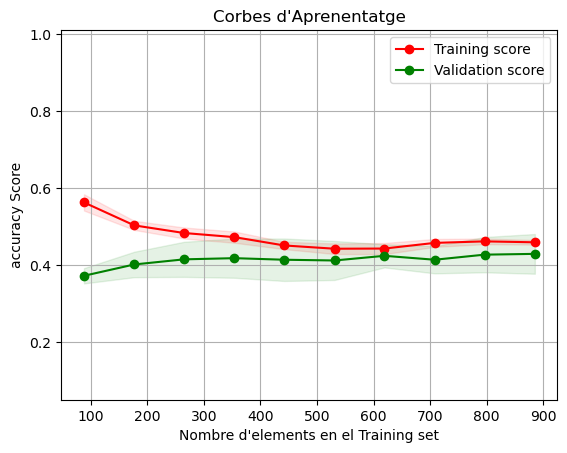

Visualitzant Overfitting del següent model: KNN


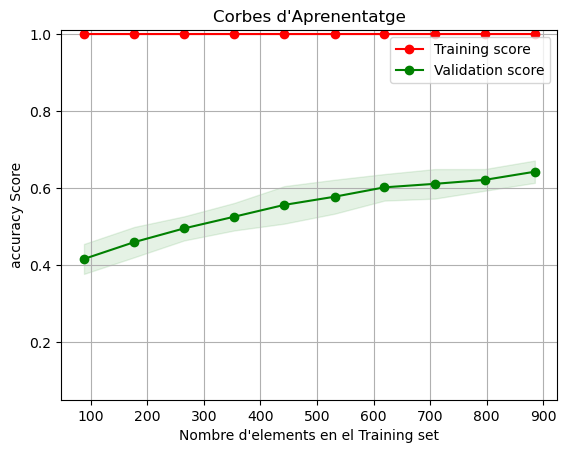

Visualitzant Overfitting del següent model: Àrbres de decisió


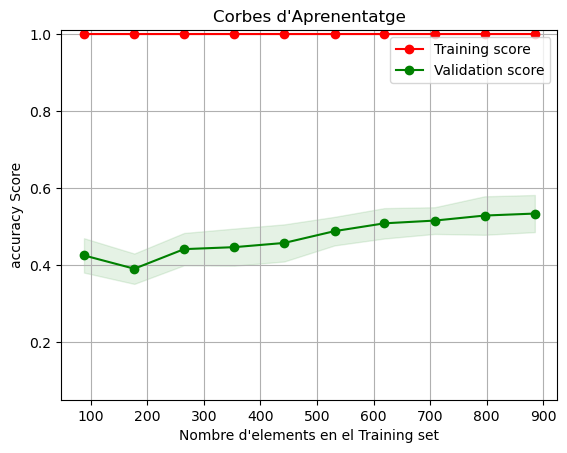

Visualitzant Overfitting del següent model: Random Forest


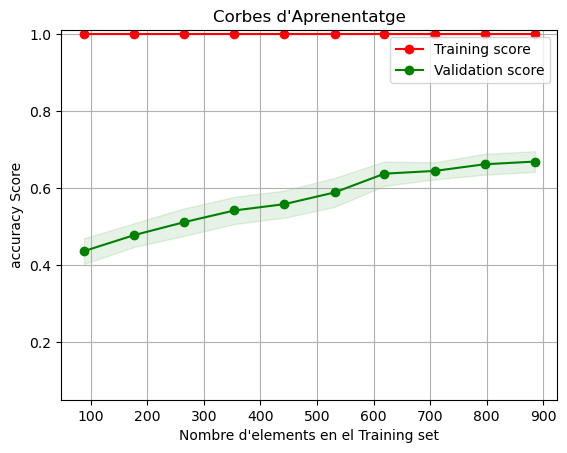

Visualitzant Overfitting del següent model: Xarxes Neuronals Artificials


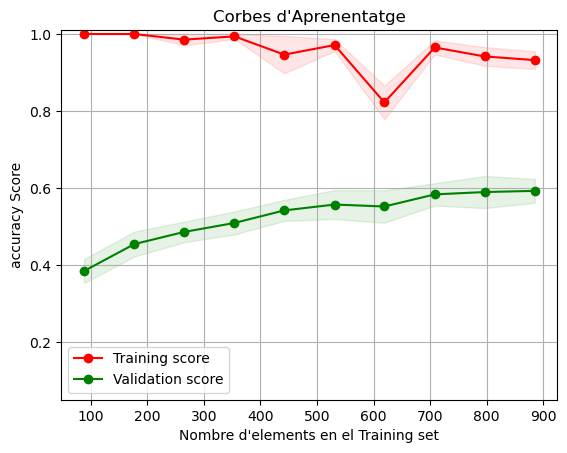

In [46]:
for model_name, model in millors_models.items():
    print(f"Visualitzant Overfitting del següent model: {model_name}")
    train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=10, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    plot_learning_curve(train_sizes, train_scores, val_scores, scoring="accuracy",ylim=(0.05, 1.01))

Podem observar que es produeix un clar overfitting en tots els casos, excepte el del regressor logístic que tot i donar uns resultats a prop del 45% no produeix casi res d'overfitting. Anem a tractar d'aplicar un anàlisis dels components principals (PCA) per tractar de mitigar aquest sobreajustament en l'entrenament:

Visualitzant Overfitting del següent model: Regressió Logística


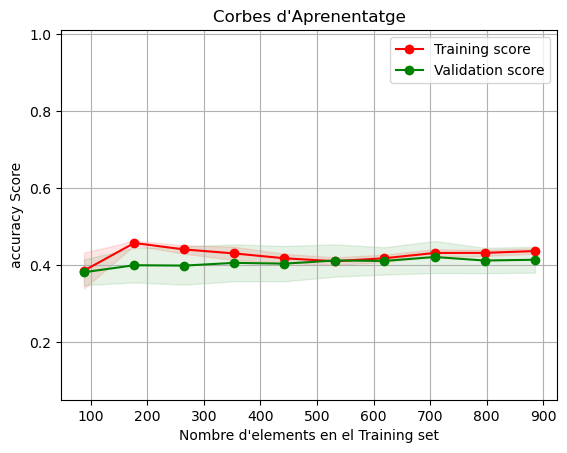

Visualitzant Overfitting del següent model: KNN


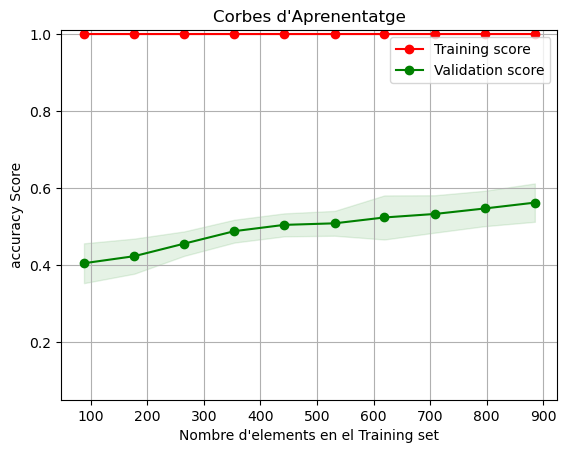

Visualitzant Overfitting del següent model: Àrbres de decisió


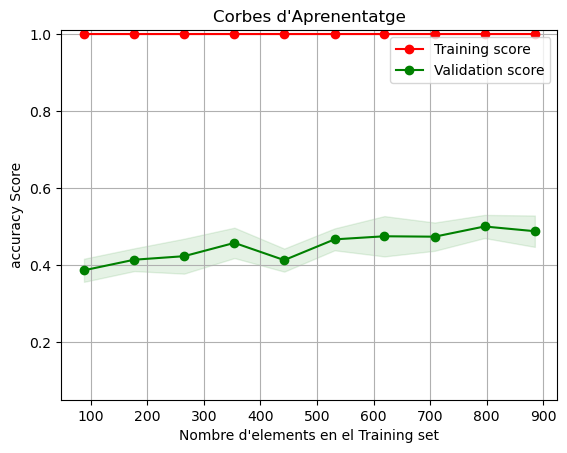

Visualitzant Overfitting del següent model: Random Forest


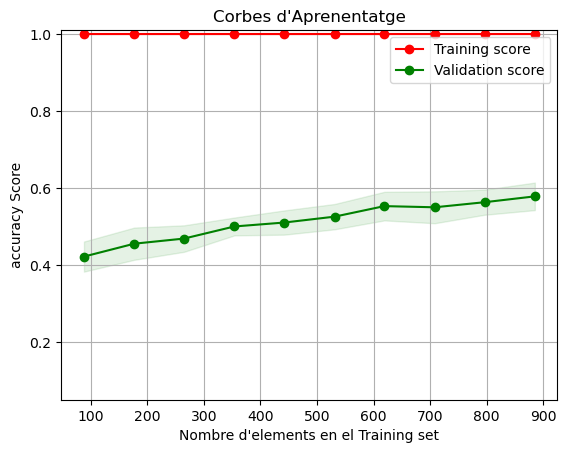

Visualitzant Overfitting del següent model: Xarxes Neuronals Artificials


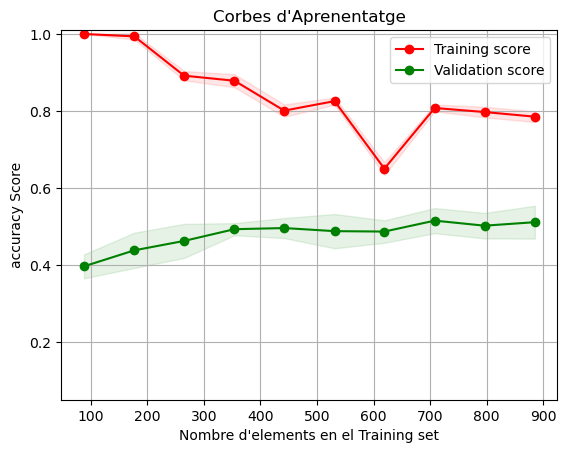

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.80)
x_trainPCA = pca.fit_transform(x_train)
for model_name, model in millors_models.items():
    print(f"Visualitzant Overfitting del següent model: {model_name}")
    train_sizes, train_scores, val_scores = learning_curve(model, x_trainPCA, y_train, cv=10, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    plot_learning_curve(train_sizes, train_scores, val_scores, scoring="accuracy",ylim=(0.05, 1.01))

No ha resultat gaire útil, a més hem perdut accuracy de validació. Podem veure que disminueix el sobreajustament en el Regressor logístic i en les Xarxes Neuronals, però no és rentable igualment.

## 4. Anàlisi Final

Per l'anàlisi final anem a mostrar la corva ROC a més de la matriu de confusió i les mètriques: accuracy, prescision, recall i f1-score amb el model que hem seleccionat que ha estat el Random Forest, junt amb els millors paràmetres que ens ha proporcionat la cerca exhaustiva.

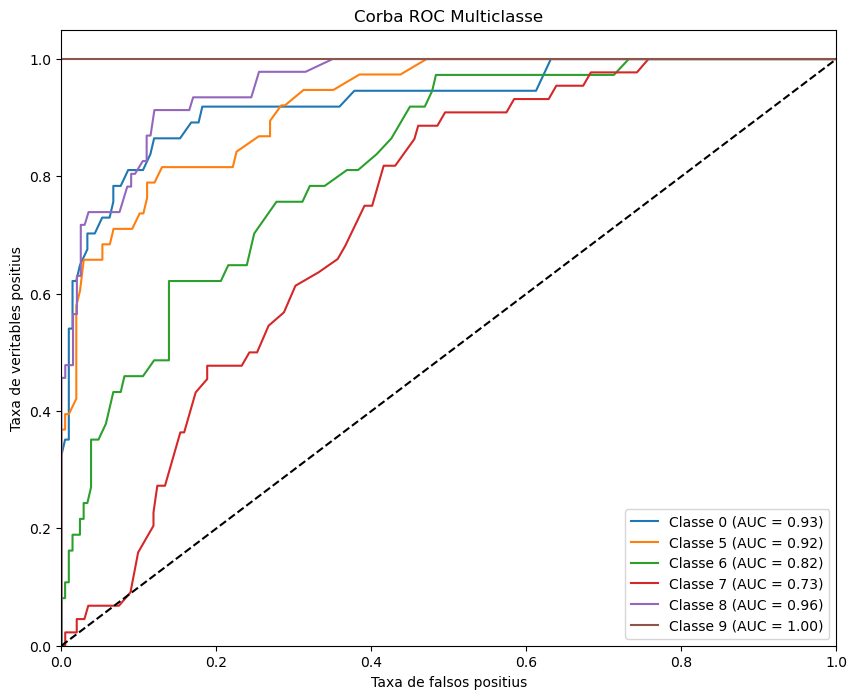

In [48]:
modelFinal = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=None)
modelFinal.fit(x_train, y_train)
mostra_corva_roc(x_test, y_test, modelFinal)

-------------------------
>>> Rendiment del model:
- Accuracy: 0.646
- Precision: 0.629
- Recall (Sensitivity, TPR): 0.645
- F1: 0.637
-------------------------


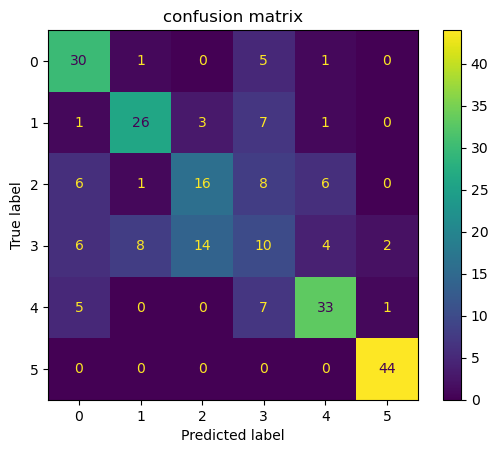

In [49]:
show_performance(x_test, y_test, modelFinal, average='macro')

Al final hem acabat amb una accuracy del 64%. Sembla ser que al classificador li costa diferenciar principalment entre les classes 6 (low pop) i 7 (mid pop), que equivalen a les files/columnes centrals de la matriu (2 i 3). Com hem dit prèviament, és possible que això sigui perquè no disposàvem de prous mostres en comparació amb aquestes classes les quals són majoritàries.
En aquest notebook no es mostren altres proves que hem fet, perquè s'hauria de tornar a executar tot i pot tenir un temps d'execució bastant elevat. Així que descriurem les proves que hem fet:

Primer de tot hem mirat d'utilitzar una tècnica en conjunt amb l'oversampling, la qual consisteix en fer l'operació inversa, és a dir, eliminar mostres de les classes majoritàries per tal de balancejar el dataframe (undersampling). Hem provat de baixar el número de mostres de les classes 6 i 7 fins a 150, i augmentar els altres també fins a 150. Però el número de mostres que generàvem sintèticament seguia sent molt gran en comparació amb el qual partiem en el pitjor cas (10 mostres per la classe 9). Llavors, no obteniem bons resultats.

Una altra prova que hem fet ha consistit en juntar algunes classes per tal d'igualar el número de mostres de les classes majoritàries de manera "natural". Per tant, hem juntat la classe 0 (que ja conté les 0, 1, 2, 3 i 4) amb la 5, i la classe 8 amb la 9. Aplicant després també el SMOTE d'oversamplig a les classes necessàries per acabar d'equilibrar el dataframe. Tot i això, els resultats obtinguts han estat un pèl estranys ja que obteniem una accuracy de validació creuada amb Grid Search al voltant del 80%. Semblava una bona solució, però al analizar la matriu de confusió ens vam trobar que teniem moltes mostres en la classe més gran, veient que s'estava produint molt overfitting a més d'haver juntat dues classes que es podien diferenciar relativament bé per l'atribut de l'any. Cal destacar també, que el nostre objectiu inicial era fer un classificador multiclasse que diferenciés entre 10 classes diferents i ho havíem reduït fins a 3, obtenint resultats poc satisfactoris, així que no ens hem volgut quedar amb una solució "trampa".

L'última prova que hem fet ha estat directament treballar amb el conjunt desbalancejat, però utilitzant el Crossvalidation Stratified, ja que en principi hauria de funcionar millor per dades desbalanjedes. No ha resultat ser així, per tant, ho hem descartat però ens hem quedat amb el Stratified K-fold que en tot cas no dona pitjors resultats que el Crossvalidation normal.

Com a conclusió, els resultats obtinguts no han estat els més bons, però tenint en compta que les dades amb les quals hem treballat estan considerablement desbalancejades i "malcuidades", hem tractat d'arreglar una mica el que hem pogut i hem obtingut uns resultats satisfactoris per tal de no allunyar-nos de l'objectiu inicial.

Per tal de millorar el model es podrien utilitzar recursos de còmput més ben preparats per tal de realitzar una cerca exhaustiva que abarqui molts més paràmetres. A més a més, utilitzar millors tècniques per tal de reduir l'overfitting ja que, malgrat totes les proves que hem realitzat no hem aconseguit reduir-lo. O provar nous models d'ensemble (com el Bagging) o Xarxes Neuronals de biblioteques més poderoses i especialitzades (com Tensorflow).